You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb


# Load Experimental data

## select files and channels

In [3]:
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_cSTA_sort_unit2']
dt = 0.01
x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [53])
i = 0
rstate_list[i] = rstate_list[i][53-1,:]
cSTA = np.correlate(x_list[i], rstate_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), rstate_list[i], 'same')
cSTA = cSTA[int(len(cSTA)/2)+1:int(len(cSTA)/2-1/dt)+1:-1]

In [4]:
Fc_list = [2, 4, 7, 10]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]
dt = 0.01
x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [53])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][53-1,:]

In [5]:
Dt = 0.01
v_list = [np.append(np.zeros(int(Dt/dt)), x[int(Dt/dt):]-x[:-int(Dt/dt)])/Dt  for x in x_list]
tv_list = [np.append(0, np.diff(x))/dt  for x in x_list]

In [6]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3)) 
t_cor_list

[0.534, 0.432, 0.405, 0.395]

In [7]:
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
vstate_list = [EqualState(v, state_num)[0] for v in v_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

# Fake Spike - DrinnenbergAdaptation

In [8]:
def TemporalKernelInput(I, K, dt):
    nK = np.append(np.zeros(len(K)-1),K)
    if len(nK) > len(I):
        print('input too short')
        return np.nan
    else:
        return np.convolve(I, nK, 'same')*dt

In [9]:
def LastKTconvolve(sti, Ky, dt):
    i = min(len(sti)-1, len(Ky)-1)
    sstm = 0
    for ii in range(i+1):
        sstm += sti[ii]*Ky[i-ii]*dt
    return(sstm)

In [18]:
C_tau_y = 0.0506 #s
C_tau_z = 0.5769 #s
gamma = 0.764
I = np.zeros_like(x_list[0])
Ttemp = np.arange(0,int(C_tau_y/dt*15))*dt
C_Ky = Ttemp/C_tau_y /C_tau_y *np.exp(-Ttemp/C_tau_y)
Ttemp = np.arange(0,int(min(C_tau_z/dt*8,len(I)/2)))*dt
C_Kz = gamma*Ttemp/C_tau_y /C_tau_y *np.exp(-Ttemp/C_tau_y)+(1-gamma)*Ttemp/C_tau_z /C_tau_z *np.exp(-Ttemp/C_tau_z)

H_tau_h = 0.371
Ttemp = np.arange(0,int(H_tau_h/dt*15))*dt
Kh =  Ttemp/H_tau_h/H_tau_h *np.exp(-Ttemp/H_tau_h)


alpha_c = -9.602E-6
alpha_h = 0.177
tau_c = 0.05
# tau_h = 1/beta
beta_c = -1.148E-5
cone_list = []
horizontal_list = []
s1_list = []
i = 3
x = x_list[i]
x = (x-min(x))/(max(x)-min(x))
sy = TemporalKernelInput(x, C_Ky, dt)
sz = TemporalKernelInput(x, C_Kz, dt)

Lum_list = [100,1000,10000, 100000, 1.0E6 ]
for Lum in Lum_list:
    s1 = sy*Lum
    s2 = sz*Lum
    cone = np.zeros(len(T_list[i]))
    horizontal = np.zeros(len(T_list[i]))
    for j in range(len(T_list[i])-1):
        dc = dt/tau_c*(-(1+beta_c*s2[j])*(cone[j]+horizontal[j]) + alpha_c*s1[j])
        cone[j+1] = cone[j]+dc
        horizontal[j+1] = alpha_h*LastKTconvolve(cone[:j+1], Kh, dt)
    cone_list.append(cone.copy())
    horizontal_list.append(horizontal.copy())
# cone_base = cone_list
# horizontal_base = horizontal_list

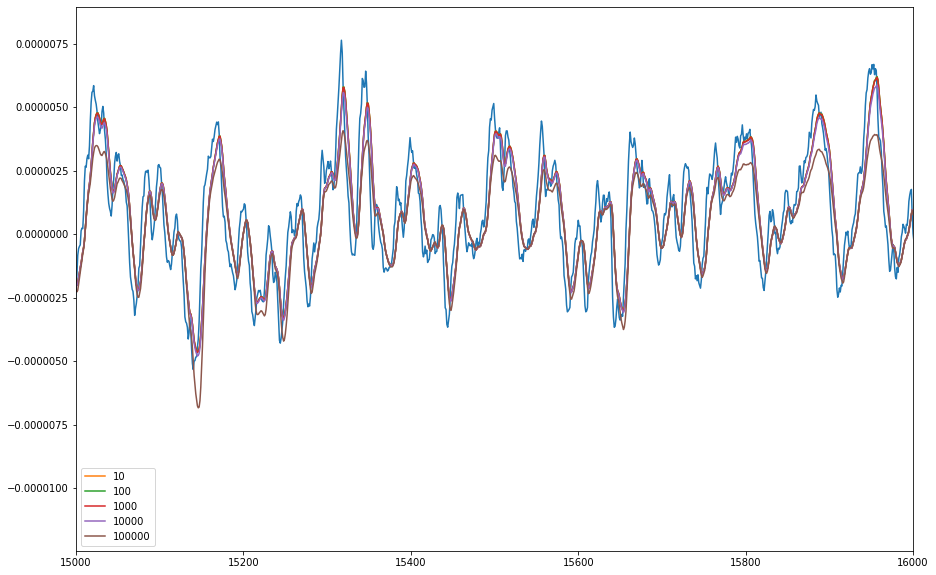

In [36]:
# plt.plot(x*alpha_c)
plt.plot(sy*alpha_c)
for L in range(len(Lum_list)):
    plt.plot(cone_list[L]/Lum_list[L], label = str(Lum_list[L]))
plt.xlim([15000, 16000])
plt.legend()
plt.gcf().set_size_inches(15, 10)

# cSTA

In [29]:
C_tau_y = 0.0506 #s
C_tau_z = 0.5769 #s
gamma = 0.764
I = np.zeros_like(x_list[0])
Ttemp = np.arange(0,int(C_tau_y/dt*15))*dt
C_Ky = Ttemp/C_tau_y /C_tau_y *np.exp(-Ttemp/C_tau_y)
Ttemp = np.arange(0,int(min(C_tau_z/dt*8,len(I)/2)))*dt
C_Kz = gamma*Ttemp/C_tau_y /C_tau_y *np.exp(-Ttemp/C_tau_y)+(1-gamma)*Ttemp/C_tau_z /C_tau_z *np.exp(-Ttemp/C_tau_z)

H_tau_h = 0.371
Ttemp = np.arange(0,int(H_tau_h/dt*15))*dt
Kh =  Ttemp/H_tau_h/H_tau_h *np.exp(-Ttemp/H_tau_h)


alpha_c = -9.602E-6
alpha_h = 0.177
tau_c = 0.05
# tau_h = 1/beta
beta_c = -1.148E-5
cone_list = []
horizontal_list = []
s1_list = []

i = 3
x = np.random.randn(len(T_list[i]))
sy = TemporalKernelInput(x, C_Ky, dt)
sz = TemporalKernelInput(x, C_Kz, dt)

Lum_list = [10, 100,1000,10000, 100000]
for Lum in Lum_list:
    s1 = sy*Lum
    s2 = sz*Lum
    cone = np.zeros(len(T_list[i]))
    horizontal = np.zeros(len(T_list[i]))
    for j in range(len(T_list[i])-1):
        dc = dt/tau_c*(-(1+beta_c*s2[j])*(cone[j]+horizontal[j]) + alpha_c*s1[j])
        cone[j+1] = cone[j]+dc
        horizontal[j+1] = alpha_h*LastKTconvolve(cone[:j+1], Kh, dt)
    cone_list.append(cone.copy())
    horizontal_list.append(horizontal.copy())

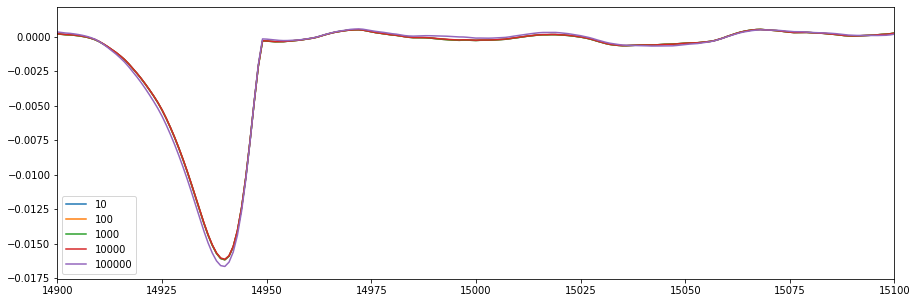

In [39]:
for L in range(len(Lum_list)):
#     NLcone = NL(cone_list[L], 0.)
    NLcone = cone_list[L]/Lum_list[L]
    XOcor = np.correlate(x, NLcone, 'same')#/np.correlate(np.ones_like(x), NLcone, 'same')
    plt.plot(XOcor, label = str(Lum_list[L]))
plt.xlim([14900, 15100])
plt.legend()
plt.gcf().set_size_inches(15, 5)

In [41]:
min(beta_c*s2)

-0.6877475670944483